![alt text](image.png)


## Customer Segmentation Using RFM Analysis


This code is my take on the Task 3 of the Elevvo Pathways Data Analyst Internship program. 
In this notebook, I shall process data from the dataset Online Retail dataset.xlsx from the UCI ML Repository for online sales. 



In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from pathlib import Path

Here, we do an initial check of the dataset.

In [2]:
file_path = "Online Retail dataset.xlsx"  # or the correct path if different
df = pd.read_excel(file_path, sheet_name="Online Retail")

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()

Shape: (541909, 8)
Columns: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Now, we move onto the next step of cleaning out our dataset to make it more relevant to our RFM Analysis. We will now apply the following steps: 
 - Removing rows with missing CustomerID - having rows without any CustomerID will not be useful to us
 - Removing negative or zero Quantity and UnitPrice - negative values can indicate returns or errors in the dataset, which can negatively impact our analysis
 - Ensuring that InvoiceDate is in the Datetime format for accuracy
 - Removing duplicate rows


Removing rows with missing CustomerID

In [ ]:
before = len(df) 
df = df.dropna(subset=['CustomerID']).copy()
after = len(df)

print(f"Removed {before - after} rows without CustomerID | Remaining rows: {after}")

Removed 135080 rows without CustomerID | Remaining rows: 406829


Removing negative or zero Quantity and UnitPrice

In [ ]:
before = len(df)
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)].copy()
after = len(df)

print(f"Removed {before - after} rows with negative or zero Quantity/UnitPrice | Remaining rows: {after}")


Removed 8945 rows with negative or zero Quantity/UnitPrice | Remaining rows: 397884


Ensuring that InvoiceDate is in the Datetime format for accuracy

In [10]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

# Removing any rows where conversion failed
df = df.dropna(subset=['InvoiceDate']).copy()


Removing duplicate rows

In [11]:
before = len(df)
df = df.drop_duplicates().copy()
after = len(df)
print(f"Removed {before - after} duplicate rows | Remaining rows: {after}")

Removed 5192 duplicate rows | Remaining rows: 392692


# Analysing Customer Behavior

In this section, we shall analyze how customers' behavior varies. Calculating this will be done on the basis of the following metrics:  

- Recency: How recently a customer made a purchase  
- Frequency: How often they made a purchase  
- Monetary: How much money they spent  

Scores will be assigned to each metric based on the following rubric:  

- Recency Score: 5 = most recent, 1 = least recent  
- Frequency Score: 5 = most frequent, 1 = least frequent  
- Monetary Score: 5 = highest spender, 1 = lowest spender  


In [4]:
import datetime as dt

# Create TotalPrice column if not already created
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

reference_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                    # Frequency
    'TotalPrice': 'sum'                                        # Monetary
}).reset_index()  

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1]).astype(int)


Recency

In [5]:
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1]).astype(int)

print(rfm[['CustomerID', 'Recency', 'R_Score']].head())

   CustomerID  Recency  R_Score
0     12346.0      326        1
1     12347.0        2        5
2     12348.0       75        2
3     12349.0       19        4
4     12350.0      310        1


Frequency

In [6]:
# Step 1: Compute F_Score dynamically
f_bins = 5  # desired number of quantiles
frequency_qcut = pd.qcut(
    rfm['Frequency'],
    q=f_bins,
    duplicates='drop'   # Handling duplicate bin edges
)

# Create labels dynamically
unique_bins = frequency_qcut.cat.categories.size
labels = range(1, unique_bins + 1)

# Apply qcut with labels
rfm['F_Score'] = pd.qcut(
    rfm['Frequency'],
    q=f_bins,
    labels=labels,
    duplicates='drop'
).astype(int)

# Step 2: Preview
print(rfm[['CustomerID', 'Frequency', 'F_Score']].head())


   CustomerID  Frequency  F_Score
0     12346.0          2        1
1     12347.0          7        3
2     12348.0          4        2
3     12349.0          1        1
4     12350.0          1        1


Monetary

In [7]:
rfm['M_Score'] = pd.qcut(
    rfm['Monetary'], 
    q=5,                          
    labels=[1, 2, 3, 4, 5],         
    duplicates='drop'                 
).astype(int)

print(rfm[['CustomerID', 'Monetary', 'M_Score']].head())


   CustomerID  Monetary  M_Score
0     12346.0      0.00        1
1     12347.0   4310.00        5
2     12348.0   1797.24        4
3     12349.0   1757.55        4
4     12350.0    334.40        2


We have now calculated the individual scores for each of the categories. Next, we will now combine the three scores into a single RFM score as follows: 

In [8]:
rfm['RFM_Total'] = rfm['R_Score'] + rfm['F_Score'] + rfm['M_Score']

print(rfm[['CustomerID', 'R_Score', 'F_Score', 'M_Score', 'RFM_Total']].head())

   CustomerID  R_Score  F_Score  M_Score  RFM_Total
0     12346.0        1        1        1          3
1     12347.0        5        3        5         13
2     12348.0        2        2        4          8
3     12349.0        4        1        4          9
4     12350.0        1        1        2          4


From the above lines of code, we have a table which contains the following columns: 
- CustomerID
- Recency
- Frequency
- Monetary 
- R_score, F_score, M_score
- Total

After assiging scores to customer, we can make better use of this information by segmenting customers on the basis of their scores. The segmentation shall be done as follows: 
- Loyal High-Value: R ≥ 4, F ≥ 4, M ≥ 4 → reward these customers
- New Customer: R = 5 → welcome campaigns
- At Risk / Inactive: R ≤ 2 → re-engagement campaigns
- Low Value / Occasional: Low F or M → minimal effort, monitor

In [9]:
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# Segmentation
def segment_customer(row):
    if row['R_Score'] >= 4 and row['F_Score'] >= 4 and row['M_Score'] >= 4:
        return 'Loyal High-Value'
    elif row['R_Score'] == 5:
        return 'New Customer'
    elif row['R_Score'] <= 2:
        return 'At Risk'
    else:
        return 'Low Value'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)

print(rfm[['CustomerID', 'RFM_Score', 'RFM_Total', 'Segment']].head())


   CustomerID RFM_Score  RFM_Total       Segment
0     12346.0       111          3       At Risk
1     12347.0       535         13  New Customer
2     12348.0       224          8       At Risk
3     12349.0       414          9     Low Value
4     12350.0       112          4       At Risk


Looking at the table above, we've calculated RFM scores for each customer, and then have combined them into a total score, and categorized them into segments: category based on behavior: "Loyal High-Value", "New Customer", "At Risk", "Low Value". This can help target market strategies based on how valuable the customer is. 

A few simple marketing ideas for each group could be thought of as follows: 

- **Loyal High-Value**
  - Offer loyalty rewards
  - Provide exclusive discounts
  - Give early access to new products

- **New Customer**
  - Send welcome emails
  - Provide onboarding offers
  - Give first-purchase discounts

- **At Risk**
  - Run re-engagement campaigns
  - Send reminder emails
  - Offer special promotions to bring them back

- **Low Value**
  - Send occasional promotions
  - Try upselling or cross-selling
  - Monitor engagement


### Conclusion

By performing RFM analysis, we cleaned and analyzed customer purchase data to calculate Recency, Frequency, and Monetary scores. Each customer was scored and segmented into groups such as **Loyal High-Value**, **New Customer**, **At Risk**, and **Low Value**. These segments provide actionable insights, allowing targeted marketing strategies like loyalty rewards, re-engagement campaigns, and promotions to improve customer retention and maximize value.



Bonus Task: Creating a summary dashboard or chart showing top 5 insights

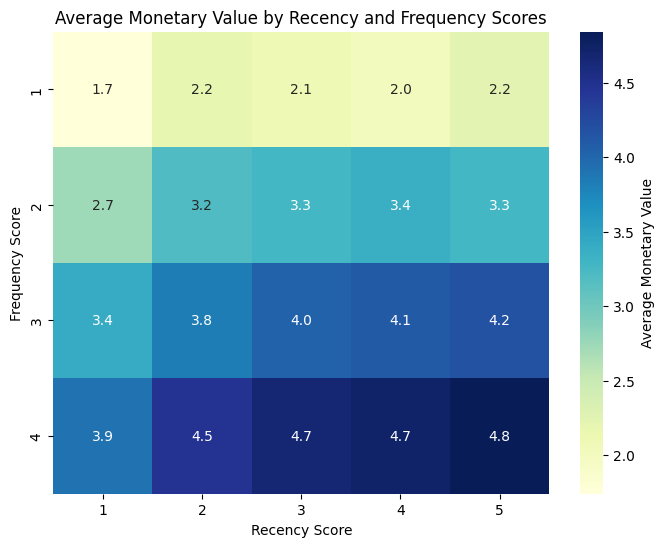

In [10]:
heatmap_data = rfm.pivot_table(
    index='F_Score',      # Frequency on y-axis
    columns='R_Score',    # Recency on x-axis
    values='M_Score',     # Monetary as the value
    aggfunc='mean'        # Average monetary value
)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    heatmap_data,
    annot=True,           # Show the numbers
    fmt=".1f",            # One decimal place
    cmap="YlGnBu",        # Color map
    cbar_kws={"label": "Average Monetary Value"}  # Colorbar label
)
plt.title("Average Monetary Value by Recency and Frequency Scores")
plt.xlabel("Recency Score")
plt.ylabel("Frequency Score")

# Show the plot
plt.show()